# ***Formulasi Masalah***


Dalam tugas ini kita akan membangun sebuah fungsi untuk memanggil suatu model machine learning yang dapat menentukan parameter yang optimal secara otomatis.\
Dataset yang digunakan adalah ***the Boston housing prices dataset*** dataset ini dapat kita gunakan untuk menentukan prediksi kenaikan harga dari kloster rumah di Boston.

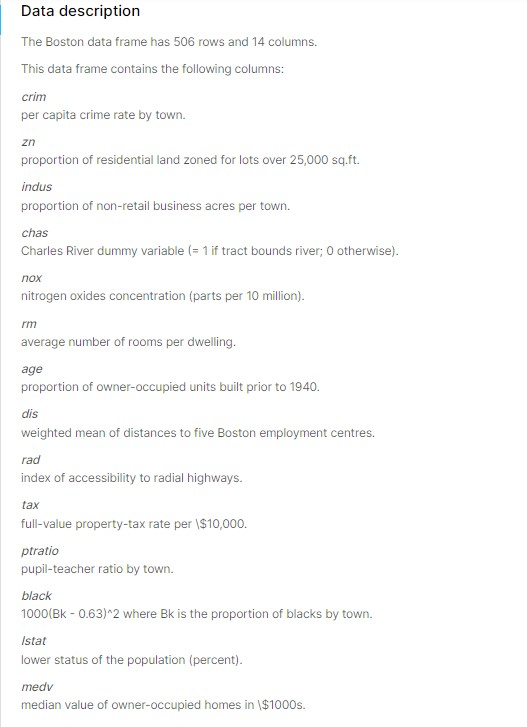

In [339]:
#Disini ter-imporlah segala library yang diperlukan dan juga menunjukkan deskripsi data yang akan dipakai

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from niapy.problems import Problem
from niapy.task import OptimizationType, Task
from niapy.algorithms.basic import GreyWolfOptimizer

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

Image(filename='Desc_Boston.jpg')

# ***Persiapan Data***

In [340]:
#Menginput dataset latih dan uji kepada algoritma
boston_train = pd.read_excel("boston_train.xlsx")
boston_test = pd.read_excel("boston_test.xlsx")
boston_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.40771,0.0,6.20,1,0.507,6.164,91.3,3.0480,8,307,17.4,395.24,21.46,21.7
1,19.60910,0.0,18.10,0,0.671,7.313,97.9,1.3163,24,666,20.2,396.90,13.44,15.0
2,6.71772,0.0,18.10,0,0.713,6.749,92.6,2.3236,24,666,20.2,0.32,17.44,13.4
3,1.51902,0.0,19.58,1,0.605,8.375,93.9,2.1620,5,403,14.7,388.45,3.32,50.0
4,9.59571,0.0,18.10,0,0.693,6.404,100.0,1.6390,24,666,20.2,376.11,20.31,12.1


In [341]:
#Memeriksa jika ada nilai yang hilang
boston_train.isnull().sum()

#Input data apa saja sebagai x dan y sebagai pembanding
x_train = boston_train[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
x_test = boston_test[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y_train = boston_train[['PRICE']]
y_test = boston_test[['PRICE']]

#Menormalisasikan data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Text(0, 0.5, 'Price')

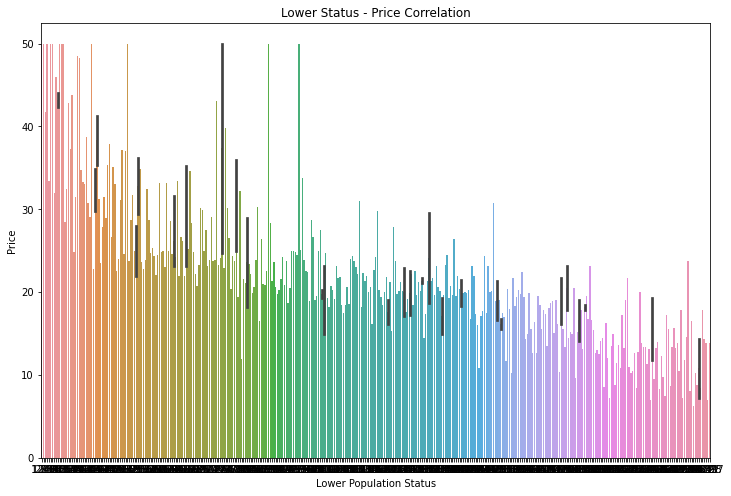

In [342]:
#Membikin barplot untuk melihat korelasi harga dan status populasi
fig = plt.figure(figsize = (12,8))
boston = sns.barplot(x = 'LSTAT', y = 'PRICE', data = boston_train)
boston.set_title( "Lower Status - Price Correlation")
 
# Menambahkan label pada X-axis
boston.set_xlabel( "Lower Population Status")
# Menambahkan label pada Y-axis
boston.set_ylabel( "Price")

Text(0, 0.5, 'Price')

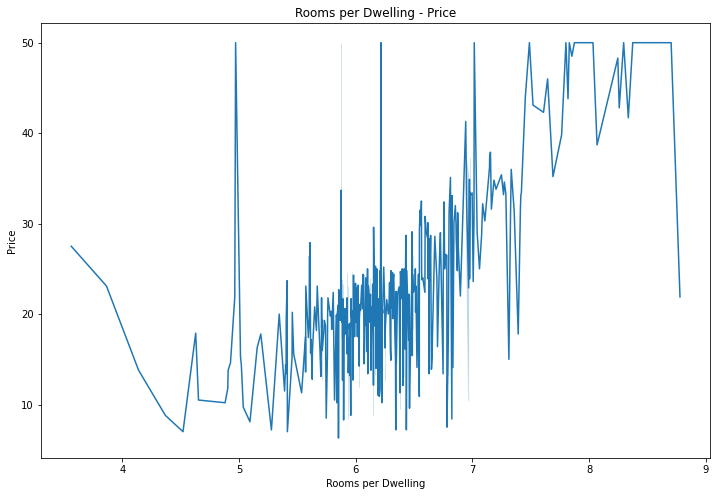

In [343]:
#Membikin barplot untuk melihat korelasi harga dan kepadatan rumah
fig = plt.figure(figsize = (12,8))
boston = sns.lineplot(x = 'RM', y = 'PRICE', data = boston_train)
boston.set_title( "Rooms per Dwelling - Price")
 
# Menambahkan label pada X-axis
boston.set_xlabel( "Rooms per Dwelling")
# Menambahkan label pada Y-axis
boston.set_ylabel( "Price")

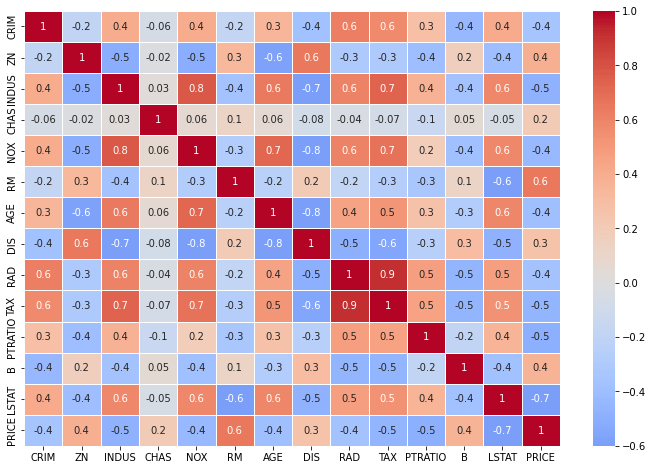

In [344]:
#Membikin heatmap untuk menentukan apa saja attribut yang berkorelasi positif dan negatif dengan harga
corr_mat = boston_train.corr()
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(corr_mat, annot=True, ax=ax, fmt='.1g', cmap='coolwarm', linewidths=.5, vmin=-0.6, vmax=1, center= 0)
plt.show()

# ***Pemodelan***

In [345]:
#Code ini terinspirasi oleh link referral https://niapy.org/en/stable/tutorials/hyperparameter_optimization.html

#Memetakan vektor solusi kita ke parameter regresi
def hyperparametersGWO(x):
    degree= round(x[1] * 10 + 5, 2)
    kernels=('linear', 'rbf', 'sigmoid')
    kernel=kernels[int(x[2] * 2)]
    gammas=('scale', 'auto')
    gamma=gammas[int(x[3])]
    C= round(x[0] * 10 + 5, 2)

    parameters = {
        'degree': degree,
        'kernel' : kernel,
        'gamma': gamma,
        'C': C,
    }

    return parameters

#Membangun regressor
def regressionGWO(x):
    parameters = hyperparametersGWO(x)
    return SVR(**parameters)

# Selanjutnya, kita perlu menulis kelas masalah khusus. 
# Masalah tersebut akan menjadi 4 dimensi, dengan batas bawah dan atas masing-masing diatur ke 0 dan 1. 
# Kelas juga akan menyimpan dataset pelatihan kami, di mana validasi silang 2 kali akan dilakukan. 
# Fungsi fitness, yang akan kita maksimalkan, akan menjadi mean dari skor validasi silang.

class OptimizationGWO(Problem):
    def __init__(self, x_train, y_train):
        super().__init__(dimension=4, lower=0, upper=1)
        self.x_train = x_train
        self.y_train = y_train

    def _evaluate(self, x):
        model = regressionGWO(x)
        scores = cross_val_score(model, self.x_train, self.y_train, cv=2, n_jobs=-1)
        return scores.mean()

# ***Eksperimen***

In [346]:
# Sekarang saatnya menjalankan algoritma.
problem = OptimizationGWO(x_train, y_train)

# Kami menetapkan jumlah maksimum iterasi ke 150
task = Task(problem, max_iters=150, optimization_type=OptimizationType.MAXIMIZATION)

# Mengatur ukuran populasi algoritma menjadi 15
algorithm = GreyWolfOptimizer(population_size=15, seed=1234)
best_params_GWO, best_accuracy = algorithm.run(task)

# ***Evaluasi***

In [347]:
# Menjalankan regressor
default_model_GWO = SVR()
best_model_GWO = regressionGWO(best_params_GWO)

# Memasukkan hasil regresi
default_model_GWO.fit(x_train, y_train)
best_model_GWO.fit(x_train, y_train)

# Menentukan nilai model 
default_score = default_model_GWO.score(x_test, y_test)
best_score_GWO = best_model_GWO.score(x_test, y_test)

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# ***Kesimpulan***

In [349]:
# Menunjukkan akurasi dari setiap model
print('Akurasi Model Bawaan   :', default_score)
print('Akurasi Model Unggulan :', best_score_GWO)

#Menunjukkan parameter dan nilai terbaik
print('Parameter Terbaik      :', hyperparametersGWO(best_params_GWO))
print('Nilai Terbaik          :', best_score_GWO)

Akurasi Model Bawaan   : 0.6652442203874216
Akurasi Model Unggulan : 0.8574725501876372
Parameter Terbaik      : {'degree': 9.73, 'kernel': 'rbf', 'gamma': 'auto', 'C': 13.59}
Nilai Terbaik          : 0.8574725501876372
